<a href="https://colab.research.google.com/github/Encark/UAS-BIGDATA/blob/main/UAS_BIG_DATA_SEMESTER_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1

Bidang yang dipilih: Logistik dan E-commerce
Alasan: Pengoptimalan waktu pengiriman penting dalam meningkatkan layanan pelanggan.
Informasi dataset:
root
 |-- Order_ID: string (nullable = true)
 |-- Agent_Age: integer (nullable = true)
 |-- Agent_Rating: double (nullable = true)
 |-- Store_Latitude: double (nullable = true)
 |-- Store_Longitude: double (nullable = true)
 |-- Drop_Latitude: double (nullable = true)
 |-- Drop_Longitude: double (nullable = true)
 |-- Order_Date: date (nullable = true)
 |-- Order_Time: string (nullable = true)
 |-- Pickup_Time: timestamp (nullable = true)
 |-- Weather: string (nullable = true)
 |-- Traffic: string (nullable = true)
 |-- Vehicle: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Delivery_Time: integer (nullable = true)
 |-- Category: string (nullable = true)

Jumlah data: 43739
Contoh data:
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+----------------

<ipython-input-1-0d4307303c33>:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_df, x="Traffic", palette="viridis")


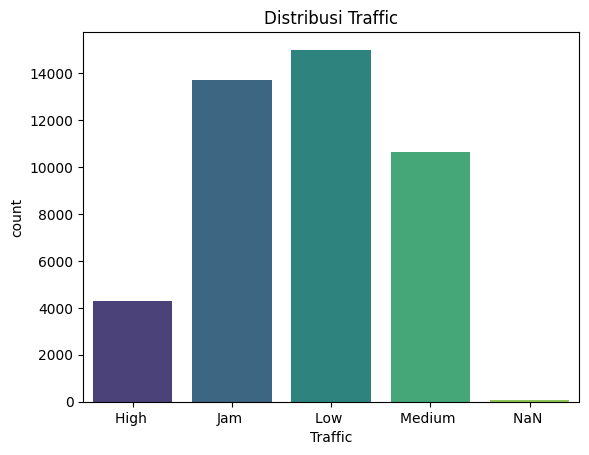

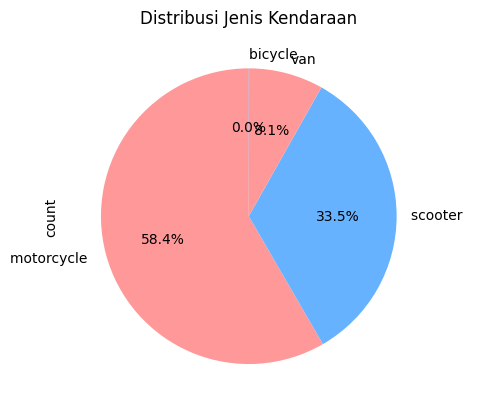

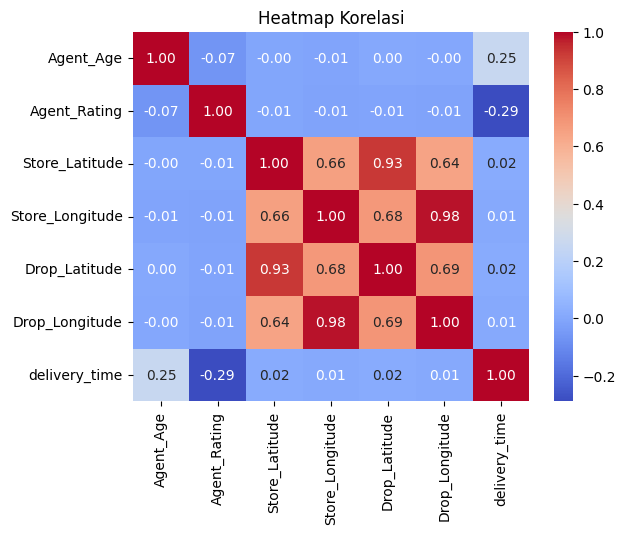

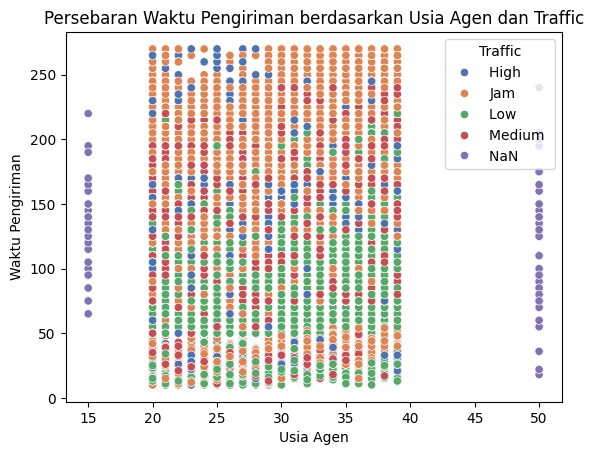



Fitur yang dipilih:
- Traffic: Karena mempengaruhi waktu pengiriman.
- Weather: Karena kondisi cuaca dapat memperlambat pengiriman.
- Agent_Age: Sebagai faktor pengalaman agen dalam pengiriman.


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, mean
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("AmazonDeliveryAnalysis").getOrCreate()

# Memuat dataset
data_path = "/content/amazon_delivery.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# ========================================
# a. PILIH BIDANG DAN ALASAN
# ========================================
def a_field_selection():
    """
    a. Pilih bidang dan alasan.
    """
    print("Bidang yang dipilih: Logistik dan E-commerce")
    print("Alasan: Pengoptimalan waktu pengiriman penting dalam meningkatkan layanan pelanggan.")

# ========================================
# b. PENJELASAN DATA
# ========================================
def b_data_description(df):
    """
    b. Penjelasan data.
    """
    print("Informasi dataset:")
    df.printSchema()
    print("Jumlah data:", df.count())
    print("Contoh data:")
    df.show(5)

# ========================================
# c. PREPROCESSING DATA
# ========================================
def c_preprocessing(df):
    """
    c. Preprocessing data.
    """
    print("Menampilkan tipe data awal:")
    df.printSchema()

    # Memeriksa nilai null hanya untuk kolom numerik
    numeric_columns = [f.name for f in df.schema.fields if str(f.dataType) in ["IntegerType", "DoubleType", "FloatType"]]
    print("Jumlah nilai null pada kolom numerik:")
    null_counts = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in numeric_columns])
    null_counts.show()

    # Memeriksa nilai null pada kolom non-numerik
    non_numeric_columns = [f.name for f in df.schema.fields if f.name not in numeric_columns]
    print("Jumlah nilai null pada kolom non-numerik:")
    null_counts_non_numeric = df.select([count(when(col(c).isNull(), c)).alias(c) for c in non_numeric_columns])
    null_counts_non_numeric.show()

    # Mengganti nama kolom untuk konsistensi
    df = df.withColumnRenamed("Delivery_Time", "delivery_time")

    # Ubah tipe kolom waktu jika diperlukan
    df = df.withColumn("delivery_time", col("delivery_time").cast("int"))

    # Membersihkan nilai yang tidak valid dalam kolom numerik
    for col_name in numeric_columns:
        df = df.withColumn(col_name, when(col(col_name).cast("float").isNotNull(), col(col_name).cast("float")).otherwise(None))

    return df

# ========================================
# d. ANALISIS DATA EKSPLORATORI (EDA)
# ========================================
def d_eda(df):
    """
    d. EDA.
    """
    # Konversi ke Pandas untuk visualisasi
    pandas_df = df.toPandas()

    # Identifikasi kolom numerik yang valid
    numeric_columns = ["Agent_Age", "delivery_time"]  # Ganti dengan kolom yang valid
    for col_name in numeric_columns:
        # Hanya konversi kolom numerik, hindari kolom yang berisi string
        pandas_df[col_name] = pd.to_numeric(pandas_df[col_name], errors="coerce")

    # Drop baris dengan nilai null pada kolom numerik
    pandas_df = pandas_df.dropna(subset=numeric_columns)

    # Visualisasi bar chart
    sns.countplot(data=pandas_df, x="Traffic", palette="viridis")
    plt.title("Distribusi Traffic")
    plt.show()

    # Visualisasi pie chart
    pandas_df["Vehicle"].value_counts().plot.pie(autopct="%1.1f%%", colors=["#FF9999", "#66B2FF"], startangle=90)
    plt.title("Distribusi Jenis Kendaraan")
    plt.show()

    # Visualisasi heatmap korelasi
    numeric_df = pandas_df.select_dtypes(include=np.number)
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Heatmap Korelasi")
    plt.show()

    # Visualisasi persebaran titik (scatter plot)
    sns.scatterplot(data=pandas_df, x="Agent_Age", y="delivery_time", hue="Traffic", palette="deep")
    plt.title("Persebaran Waktu Pengiriman berdasarkan Usia Agen dan Traffic")
    plt.xlabel("Usia Agen")
    plt.ylabel("Waktu Pengiriman")
    plt.show()

# ========================================
# e. PEMILIHAN FITUR
# ========================================
def e_feature_selection(df):
    """
    e. Pemilihan fitur berdasarkan analisis.
    """
    print("Fitur yang dipilih:")
    print("- Traffic: Karena mempengaruhi waktu pengiriman.")
    print("- Weather: Karena kondisi cuaca dapat memperlambat pengiriman.")
    print("- Agent_Age: Sebagai faktor pengalaman agen dalam pengiriman.")

# Menjalankan setiap bagian
a_field_selection()
b_data_description(df)

# Preprocessing dan pembaruan dataset
df_cleaned = c_preprocessing(df)

# Melakukan EDA
d_eda(df_cleaned)
print("\n")

# Pemilihan fitur
e_feature_selection(df_cleaned)


#2

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, mean
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

# Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("Amazon Delivery Classification") \
    .getOrCreate()

# Memuat dataset
file_path = "/content/amazon_delivery.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Membuat kolom target klasifikasi
df = df.withColumn(
    "Delivery_Class",
    when(df["Delivery_Time"] < 120, "Cepat")
    .when((df["Delivery_Time"] >= 120) & (df["Delivery_Time"] <= 180), "Sedang")
    .otherwise("Lambat")
)

# Mengubah label menjadi numerik
label_indexer = StringIndexer(inputCol="Delivery_Class", outputCol="label")
df = label_indexer.fit(df).transform(df)

# Memilih fitur yang relevan
feature_cols = ["Agent_Age", "Agent_Rating", "Store_Latitude", "Store_Longitude",
                "Drop_Latitude", "Drop_Longitude"]

# Menangani nilai null
def handle_missing_values(dataframe, feature_cols):
    for col_name in feature_cols:
        mean_value = dataframe.select(mean(col(col_name))).collect()[0][0]
        dataframe = dataframe.fillna({col_name: mean_value})
    return dataframe

df = handle_missing_values(df, feature_cols)

# Memastikan tipe data numerik
for col_name in feature_cols:
    df = df.withColumn(col_name, col(col_name).cast("double"))

# Menggabungkan fitur menjadi vektor
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Membagi dataset menjadi training dan testing
train, test = df.randomSplit([0.8, 0.2], seed=42)

# Menginisialisasi model
models = {
    "RandomForest": RandomForestClassifier(featuresCol="features", labelCol="label", seed=42),
    "GradientBoostedTree": GBTClassifier(featuresCol="features", labelCol="label", seed=42),
    "LogisticRegression": LogisticRegression(featuresCol="features", labelCol="label", maxIter=10),
    "MultilayerPerceptron": MultilayerPerceptronClassifier(featuresCol="features", labelCol="label",
                                                           layers=[len(feature_cols), 10, 5, 3], seed=42)
}

# Evaluasi model
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# Mengidentifikasi apakah label terdiri dari lebih dari dua kelas
label_distinct = df.select("label").distinct().count()

if label_distinct > 2:
    print("Gradient Boosted Tree hanya mendukung binary classification.")
    print("Mengganti model Gradient Boosted Tree dengan Decision Tree Classifier.")
    from pyspark.ml.classification import DecisionTreeClassifier
    models["DecisionTree"] = DecisionTreeClassifier(featuresCol="features", labelCol="label")
    del models["GradientBoostedTree"]

# Evaluasi model
results = {}

for model_name, model in models.items():
    pipeline = Pipeline(stages=[assembler, model])
    pipeline_model = pipeline.fit(train)
    predictions = pipeline_model.transform(test)

    # Evaluasi dengan Multi-class Classification Evaluator
    evaluator_accuracy = MulticlassClassificationEvaluator(metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(metricName="weightedRecall")

    accuracy = evaluator_accuracy.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)

    results[model_name] = {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

    print(f"Model: {model_name}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}")

# Menampilkan model terbaik berdasarkan akurasi
best_model_name = max(results, key=lambda x: results[x]["accuracy"])
best_model_metrics = results[best_model_name]
print(f"\nModel terbaik adalah {best_model_name} dengan metrik:")
print(f"Accuracy: {best_model_metrics['accuracy']:.4f}, F1: {best_model_metrics['f1']:.4f}, "
      f"Precision: {best_model_metrics['precision']:.4f}, Recall: {best_model_metrics['recall']:.4f}")

# Hyperparameter tuning untuk model terbaik
if best_model_name in ["RandomForest", "GradientBoostedTree"]:
    best_model = models[best_model_name]

    param_grid = ParamGridBuilder() \
        .addGrid(best_model.maxDepth, [5, 10]) \
        .addGrid(best_model.numTrees, [20, 50]) \
        .build()

    crossval = CrossValidator(estimator=Pipeline(stages=[assembler, best_model]),
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=3)

    cv_model = crossval.fit(train)
    tuned_predictions = cv_model.transform(test)
    tuned_accuracy = evaluator.evaluate(tuned_predictions)
    print(f"Setelah tuning, akurasi model {best_model_name} meningkat menjadi {tuned_accuracy:.4f}")

Gradient Boosted Tree hanya mendukung binary classification.
Mengganti model Gradient Boosted Tree dengan Decision Tree Classifier.
Model: RandomForest, Accuracy: 0.5599, F1: 0.5240, Precision: 0.5742, Recall: 0.5599
Model: LogisticRegression, Accuracy: 0.5379, F1: 0.5038, Precision: 0.5249, Recall: 0.5379
Model: MultilayerPerceptron, Accuracy: 0.5357, F1: 0.4890, Precision: 0.4524, Recall: 0.5357
Model: DecisionTree, Accuracy: 0.5583, F1: 0.5260, Precision: 0.5628, Recall: 0.5583

Model terbaik adalah RandomForest dengan metrik:
Accuracy: 0.5599, F1: 0.5240, Precision: 0.5742, Recall: 0.5599
Setelah tuning, akurasi model RandomForest meningkat menjadi 0.5618
